<a href="https://colab.research.google.com/github/rachelszeto/Projects/blob/main/DB_Dating_App_Behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import re

In [4]:
# Load the Dataset
dataset_link = '/content/drive/MyDrive/DataBlog S25/Data sets/cleaned_lovoo_dataset.csv'
df = pd.read_csv(dataset_link)

# Check load correctly
df.head()

,index_instance,gender_instance,age_instance,counts_pictures_instance,counts_profileVisits_instance,counts_kisses_instance,flirtInterests_chat_instance,flirtInterests_friends_instance,flirtInterests_date_instance,connectedToFacebook,...,lang_de_api,lang_it_api,lang_es_api,lang_pt_api,verified,shareProfileEnabled,lastOnlineDate,lastOnlineTime,birthd,whazzup_api
0,0,F,25,4,8279,239,True,True,True,False,...,True,False,False,False,0,1,2015-04-25T20:43:26Z,1.429995e+09,0,Nur tote fische schwimmen mit dem strom
1,1,F,22,5,663,13,True,True,True,False,...,True,True,False,False,0,1,2015-04-26T09:19:35Z,1.430040e+09,0,Primaveraaa<3
2,2,F,20,3,22187,1015,True,True,False,False,...,False,False,False,False,0,1,2015-04-07T11:21:01Z,1.428406e+09,0,Je pense donc je suis. Instagram quedev
3,3,F,24,18,7339,180,True,False,True,False,...,True,False,False,False,0,1,2015-04-08T14:37:51Z,1.428504e+09,0,Wicked Wonderland💕❤️
4,4,F,24,13,18672,492,False,True,False,False,...,True,False,False,False,0,1,2015-04-27T19:29:58Z,1.430163e+09,0,💚 ✅ Instagram : anna_lem0n


### EDA

### Does the emoji usage rate correlate with messaging behavior or success in forming mutual matches?

In [5]:
# Does emoji usage rate correlate with messaging behavior or success in forming mutual matches?
emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)

# Filter to English-speaking users with non-null 'whazzup'
df_emoji = df[(df['lang_en_instance'] == True) & df['whazzup_instance'].notnull()].copy()

# Count emojis using regex and calculate emoji rate
df_emoji['emoji_count'] = df_emoji['whazzup_instance'].apply(lambda x: len(emoji_pattern.findall(x)))
df_emoji['text_length'] = df_emoji['whazzup_instance'].apply(len)
df_emoji['emoji_rate'] = df_emoji['emoji_count'] / df_emoji['text_length']

# Correlation with engagement metrics
correlation_kisses = df_emoji['emoji_rate'].corr(df_emoji['counts_kisses_instance'])
correlation_visits = df_emoji['emoji_rate'].corr(df_emoji['counts_profileVisits_instance'])

correlation_kisses, correlation_visits

(np.float64(0.1291180227305557), np.float64(0.12833401962580154))

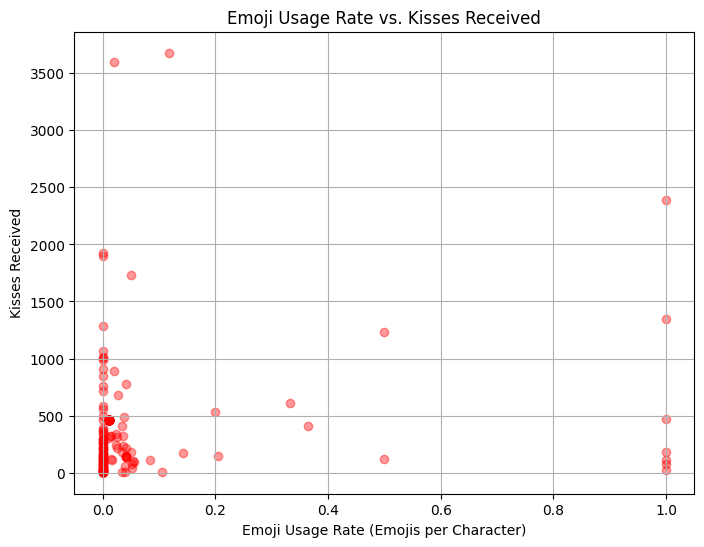

In [6]:
# Scatter plot for emoji rate vs kisses received
plt.figure(figsize=(8, 6))
plt.scatter(df_emoji['emoji_rate'], df_emoji['counts_kisses_instance'], alpha=0.4,color='red')
plt.title('Emoji Usage Rate vs. Kisses Received')
plt.xlabel('Emoji Usage Rate (Emojis per Character)')
plt.ylabel('Kisses Received')
plt.grid(True)
plt.show()

# Result: There is a weak positive correlation between emoji usage and both:
#         Kisses received (correlation ≈ 0.13)
#         Profile visits (correlation ≈ 0.13)
# Interpretation: Users who use emojis in their status tend to receive slightly more attention,
#                 but emoji usage alone is not a strong predictor of engagement.

In [7]:
# Emoji extraction and emoji rate calculation
emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)
df_emoji = df[(df['lang_en_instance'] == True) & df['whazzup_instance'].notnull()].copy()
df_emoji['emoji_count'] = df_emoji['whazzup_instance'].apply(lambda x: len(emoji_pattern.findall(x)))
df_emoji['text_length'] = df_emoji['whazzup_instance'].apply(len)
df_emoji['emoji_rate'] = df_emoji['emoji_count'] / df_emoji['text_length']

# Filter for log scale
df_emoji_filtered = df_emoji[df_emoji['counts_kisses_instance'] > 0]

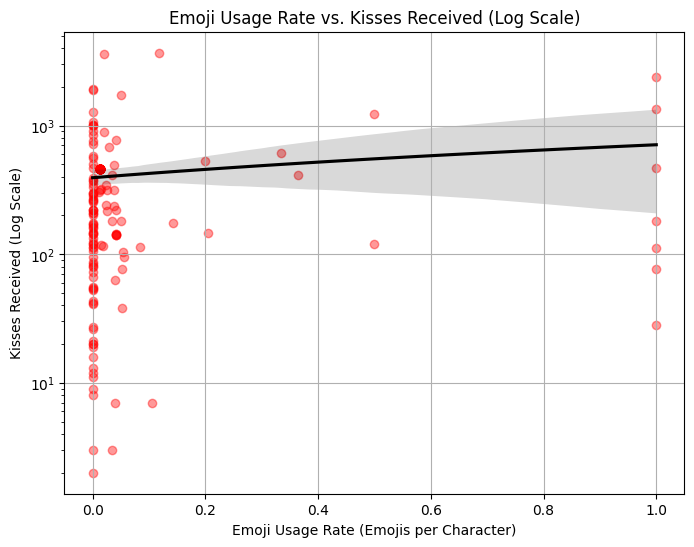

In [8]:
# Create the log scale plot
plt.figure(figsize=(8, 6))
sns.regplot(
    x='emoji_rate',
    y='counts_kisses_instance',
    data=df_emoji_filtered,
    scatter_kws={'alpha': 0.4, 'color': 'red'},
    line_kws={'color': 'black'}
)
plt.yscale('log')
plt.title('Emoji Usage Rate vs. Kisses Received (Log Scale)')
plt.xlabel('Emoji Usage Rate (Emojis per Character)')
plt.ylabel('Kisses Received (Log Scale)')
plt.grid(True)
plt.show()

### Does the time of day when users are most active influence their likelihood of receiving a match?

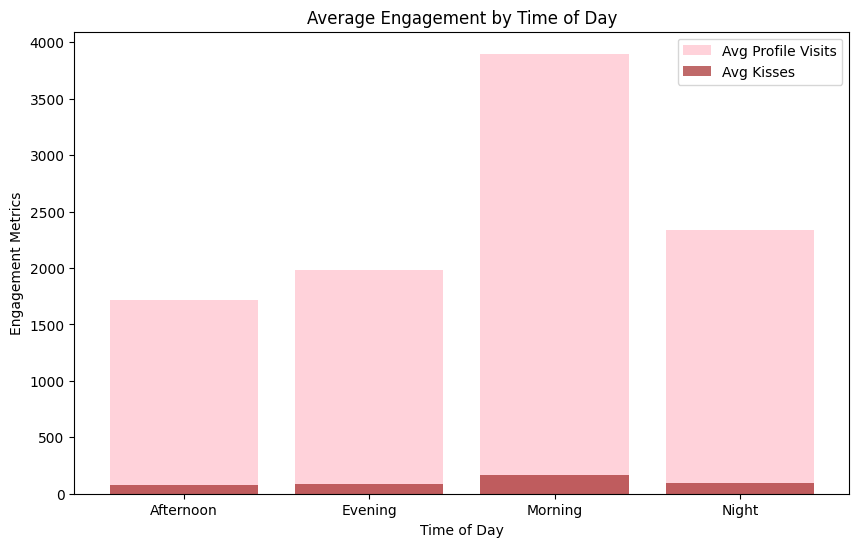

In [ ]:
# Convert timestamp (seconds) to hour of day
df_active = df[df['lastOnlineTime'].notnull()].copy()
df_active['hour'] = pd.to_datetime(df_active['lastOnlineTime'], unit='s').dt.hour

# Group users into time-of-day bins
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_active['time_of_day'] = df_active['hour'].apply(time_of_day)

# Calculate average kisses and visits by time of day
time_grouped = df_active.groupby('time_of_day')[['counts_kisses_instance', 'counts_profileVisits_instance']].mean().reset_index()

# Create bar chart for average engagement by time of day
plt.figure(figsize=(10, 6))
plt.bar(time_grouped['time_of_day'], time_grouped['counts_profileVisits_instance'], alpha=0.7, color = 'pink', label='Avg Profile Visits')
plt.bar(time_grouped['time_of_day'], time_grouped['counts_kisses_instance'], alpha=0.7, label='Avg Kisses', color ='brown')
plt.title('Average Engagement by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Engagement Metrics')
plt.legend()
plt.grid(axis='y')
plt.grid(False)
plt.show()

# Result: Morning users (5 a.m. – 12 p.m.) received the highest average engagement:
#         ~169 kisses
#         ~3,898 profile visits
#         Engagement dropped during the Afternoon, then increased again in the Evening and Night
# Interpretation: Users active in the morning experience significantly higher engagement,
#                 suggesting that time of day plays a meaningful role in visibility and potential match outcomes.